##### A sample circuit netlist file processing and visualization.

##### Dataset link: `https://github.com/jpsety/verilog_benchmark_circuits`

Graph has 13 nodes and 14 edges.
Primary Inputs: {'N3', 'N7', 'N6', 'N2', 'N1'}
Primary Outputs: {'N23', 'N22'}


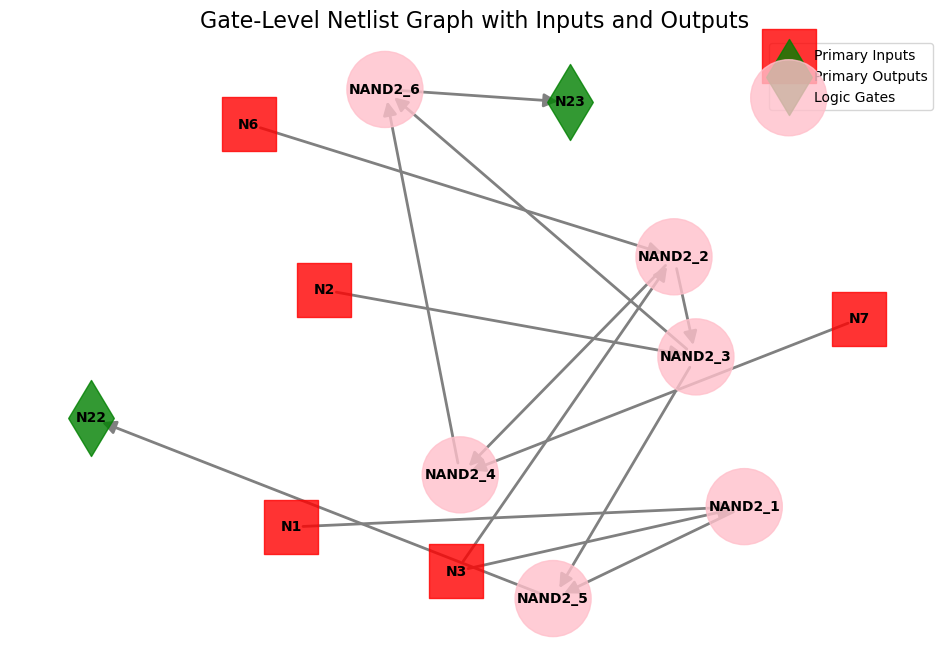

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import re

def parse_verilog_netlist(verilog_file):
    """
    Parses a Verilog gate-level netlist file and converts it into a NetworkX directed graph.
    Identifies primary inputs and primary outputs and connects them properly.
    """
    G = nx.DiGraph()
    
    gate_types = ['and', 'or', 'nand', 'nor', 'xor', 'xnor', 'buf', 'not']
    gates = {}
    all_signals = set()
    output_signals = set()
    input_signals = set()

    with open(verilog_file, 'r') as f:
        lines = f.readlines()

    # Regex pattern to extract gate instances
    gate_pattern = re.compile(rf'\s*({"|".join(gate_types)})\s+(\w+)\s*\((.*)\);')
    
    for line in lines:
        line = line.strip()
        match = gate_pattern.match(line)
        if match:
            gate_type, gate_name, connection_str = match.groups()
            
            signals = [sig.strip() for sig in connection_str.split(',')]
            output_signal = signals[0]  # First signal is the output
            input_signals.update(signals[1:])  # Remaining are inputs

            # Track all signals and outputs
            all_signals.update(signals)
            output_signals.add(output_signal)

            gates[output_signal] = (gate_name, gate_type, signals[1:])
            G.add_node(gate_name, type=gate_type)  # Add gate node

    # Find primary inputs (signals used as inputs but never assigned as an output)
    primary_inputs = input_signals - output_signals

    # Find primary outputs (signals assigned as an output but never used as an input)
    primary_outputs = output_signals - input_signals

    # Add edges based on input-output connections
    for output_signal, (gate_name, gate_type, input_signals) in gates.items():
        for inp in input_signals:
            if inp in gates:
                input_gate_name = gates[inp][0]
                G.add_edge(input_gate_name, gate_name)  # Connect input gate to current gate
            elif inp in primary_inputs:
                G.add_edge(inp, gate_name)  # Connect primary input to current gate

    # Ensure primary inputs are explicitly added to the graph
    for pi in primary_inputs:
        G.add_node(pi, type="input")

    # Ensure primary outputs are explicitly added to the graph and connected properly
    for po in primary_outputs:
        G.add_node(po, type="output")
        if po in gates:
            G.add_edge(gates[po][0], po)  # Connect the producing gate to the primary output

    return G, primary_inputs, primary_outputs

def visualize_circuit_graph(G, primary_inputs, primary_outputs):
    """
    Visualizes the gate-level netlist graph with primary inputs and outputs.
    """
    plt.figure(figsize=(12, 8))

    # Compute positions after ensuring all nodes exist
    pos = nx.spring_layout(G, k=1.5, iterations=50)

    # Identify different node types
    gate_nodes = [n for n in G.nodes if n not in primary_inputs and n not in primary_outputs]

    # Draw primary inputs as squares
    if primary_inputs:
        nx.draw_networkx_nodes(G, pos, nodelist=primary_inputs, node_color='red', node_size=1500, node_shape='s', alpha=0.8, label="Primary Inputs")

    # Draw primary outputs as diamonds
    if primary_outputs:
        nx.draw_networkx_nodes(G, pos, nodelist=primary_outputs, node_color='green', node_size=1500, node_shape='d', alpha=0.8, label="Primary Outputs")

    # Draw gate nodes as circles
    node_colors = {'and': 'lightblue', 'or': 'lightgreen', 'nand': 'pink', 'nor': 'purple',
                   'xor': 'yellow', 'xnor': 'orange', 'buf': 'cyan', 'not': 'gray'}
    colors = [node_colors.get(G.nodes[n]['type'], 'gray') for n in gate_nodes]
    
    if gate_nodes:
        nx.draw_networkx_nodes(G, pos, nodelist=gate_nodes, node_color=colors, node_size=3000, alpha=0.8, label="Logic Gates")

    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=20, width=2)

    # Draw labels
    labels = {node: node for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight='bold')

    plt.legend()
    plt.title("Gate-Level Netlist Graph with Inputs and Outputs", fontsize=16)
    plt.axis('off')
    plt.show()


# Example usage
if __name__ == "__main__":
    verilog_file = "verilog_benchmark_circuits-master/c17.v"  # Update with your file path
    circuit_graph, primary_inputs, primary_outputs = parse_verilog_netlist(verilog_file)
    
    print(f"Graph has {circuit_graph.number_of_nodes()} nodes and {circuit_graph.number_of_edges()} edges.")
    print(f"Primary Inputs: {primary_inputs}")
    print(f"Primary Outputs: {primary_outputs}")
    
    # Visualize the graph
    visualize_circuit_graph(circuit_graph, primary_inputs, primary_outputs)


##### To train a GCNN, the dataset should include:

Graph Structures: The NetworkX graphs representing each circuit.

Extract Features based on:
- Gate-Level Features
- Connectivity Features
- Structural Features
- Graph-Based Features

In [18]:
import networkx as nx
import pandas as pd
import os
import re
from networkx.exception import NetworkXNoPath

def parse_verilog_netlist(verilog_file):
    """
    Parses a gate-level Verilog netlist and constructs a directed graph.
    Returns the graph, gate dictionary, primary inputs, and primary outputs.
    """
    G = nx.DiGraph()
    gate_types = ['and', 'or', 'nand', 'nor', 'xor', 'xnor', 'buf', 'not']
    gates = {}
    all_signals = set()
    output_signals = set()
    input_signals = set()

    with open(verilog_file, 'r') as f:
        lines = f.readlines()

    print(f'Number of lines in this file: {len(lines)}')
    gate_pattern = re.compile(rf'\s*({"|".join(gate_types)})\s+(\w+)\s*\((.*)\);')

    
    for count_line,line in enumerate(lines):
        if count_line %1000 == 0: print(f'Processing line: {count_line}')
        line = line.strip()
        match = gate_pattern.match(line)
        if match:
            gate_type, gate_name, connection_str = match.groups()
            signals = [sig.strip() for sig in connection_str.split(',')]
            output_signal = signals[0]
            input_signals.update(signals[1:])

            all_signals.update(signals)
            output_signals.add(output_signal)

            gates[output_signal] = (gate_name, gate_type, signals[1:])
            G.add_node(gate_name, type=gate_type)

    primary_inputs = input_signals - output_signals
    primary_outputs = output_signals - input_signals

    for output_signal, (gate_name, gate_type, input_signals) in gates.items():
        for inp in input_signals:
            if inp in gates:
                G.add_edge(gates[inp][0], gate_name)
            elif inp in primary_inputs:
                G.add_edge(inp, gate_name)

    for pi in primary_inputs:
        G.add_node(pi, type="input")

    for po in primary_outputs:
        G.add_node(po, type="output")
        if po in gates:
            G.add_edge(gates[po][0], po)

    return G, gates, primary_inputs, primary_outputs

def extract_features(G, gates, primary_inputs, primary_outputs, circuit_name):
    """
    Extracts structural and graph-based features from the netlist.
    Handles disconnected nodes safely.
    """
    features = []
    degrees = dict(G.degree())

    # Compute graph centralities
    centrality_deg = nx.degree_centrality(G)
    centrality_betw = nx.betweenness_centrality(G, k=min(100, len(G)))  # Speed-up for large graphs
    centrality_close = nx.closeness_centrality(G)
    clustering_coeff = nx.clustering(G)
    print(f'Length of nodes: {len(G.nodes)}')
    for node in G.nodes:
        node_type = G.nodes[node]['type']
        is_primary_input = 1 if node in primary_inputs else 0
        is_primary_output = 1 if node in primary_outputs else 0
        is_internal_node = 1 if not (is_primary_input or is_primary_output) else 0

        fan_in = G.in_degree(node)
        fan_out = G.out_degree(node)

        neighbors = list(G.neighbors(node))
        avg_fan_in_neighbors = sum(G.in_degree(n) for n in neighbors) / len(neighbors) if neighbors else 0
        avg_fan_out_neighbors = sum(G.out_degree(n) for n in neighbors) / len(neighbors) if neighbors else 0

        try:
            depth = nx.shortest_path_length(G, source=node) if not is_primary_input else 0
        except (NetworkXNoPath, KeyError):
            depth = -1  # Default if no path exists

        try:
            distance_to_outputs = min(nx.shortest_path_length(G, source=node, target=po) for po in primary_outputs if nx.has_path(G, node, po)) if is_internal_node else 0
        except (NetworkXNoPath, ValueError):
            distance_to_outputs = -1  # Default if no path exists

        is_key_gate = 1 if node_type in ['xor', 'xnor'] else 0  # Logic locking gates
        key_dependency = node if is_key_gate else None

        features.append({
            'circuit_name': circuit_name,
            'node': node,
            'gate_type': node_type,
            'fan_in': fan_in,
            'fan_out': fan_out,
            'depth': depth,
            'dist_to_output': distance_to_outputs,
            'is_primary_input': is_primary_input,
            'is_primary_output': is_primary_output,
            'is_internal': is_internal_node,
            'is_key_gate': is_key_gate,
            'key_dependency': key_dependency,
            'degree_centrality': centrality_deg.get(node, 0),
            'betweenness_centrality': centrality_betw.get(node, 0),
            'closeness_centrality': centrality_close.get(node, 0),
            'clustering_coefficient': clustering_coeff.get(node, 0),
            'avg_fan_in_neighbors': avg_fan_in_neighbors,
            'avg_fan_out_neighbors': avg_fan_out_neighbors,
        })

    return pd.DataFrame(features)

def process_all_netlists(folder_path):
    """
    Processes all .v files in the folder efficiently and combines extracted features into a single DataFrame.
    """
    all_features = []
    
    print(f'Files to b processed: {os.listdir(folder_path)}')
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".v"):
            file_path = os.path.join(folder_path, filename)
            print(f"Processing: *****{filename}******")

            try:
                circuit_graph, gates, primary_inputs, primary_outputs = parse_verilog_netlist(file_path)
                circuit_features = extract_features(circuit_graph, gates, primary_inputs, primary_outputs, filename)
                all_features.append(circuit_features)
            except Exception as e:
                print(f"‚ö†Ô∏è Skipping {filename} due to error: {e}")

    if all_features:
        final_df = pd.concat(all_features, ignore_index=True)
        final_df.to_csv("all_circuits_features.csv", index=False)
        print("\n‚úÖ Feature extraction completed. Saved to all_circuits_features.csv")
    else:
        print("\n‚ùå No valid netlist files were processed.")

# Example usage
if __name__ == "__main__":
    netlist_folder = "verilog_benchmark_circuits-master"  # Update path
    process_all_netlists(netlist_folder)


Files to b processed: ['.ipynb_checkpoints', 'adder.v', 'arbiter.v', 'bar.v', 'c1355.v', 'c17.v', 'c1908.v', 'c2670.v', 'c3540.v', 'c432.v', 'c499.v', 'c5315.v', 'c6288.v', 'c7552.v', 'c880.v', 'cavlc.v', 'ctrl.v', 'dec.v', 'i2c.v', 'int2float.v', 'max.v', 'Priority.v', 'router.v', 'sin.v']
Processing: *****adder.v******
Number of lines in this file: 2595
Processing line: 0
Processing line: 1000
Processing line: 2000
Length of nodes: 2547
Processing: *****arbiter.v******
Number of lines in this file: 26540
Processing line: 0
Processing line: 1000
Processing line: 2000
Processing line: 3000
Processing line: 4000
Processing line: 5000
Processing line: 6000
Processing line: 7000
Processing line: 8000
Processing line: 9000
Processing line: 10000
Processing line: 11000
Processing line: 12000
Processing line: 13000
Processing line: 14000
Processing line: 15000
Processing line: 16000
Processing line: 17000
Processing line: 18000
Processing line: 19000
Processing line: 20000
Processing line: 2

#### Display and describe the content of `all_circuits_features.csv`.

In [1]:
import pandas as pd

# Load the extracted features CSV file
df = pd.read_csv("all_circuits_features.csv")

# Display the first few rows
print("\nüîπ First 5 rows of the DataFrame:")
print(df.head())

# Summary statistics
print("\nüîπ DataFrame Summary:")
print(df.info())

print("\nüîπ Statistical Summary:")
print(df.describe())

# Check for missing values
print("\nüîπ Missing Values in Each Column:")
print(df.isnull().sum())

# Count the number of circuits processed
num_circuits = df['circuit_name'].nunique()
num_nodes = df.shape[0]
print(f"\n‚úÖ Number of circuits processed: {num_circuits}")
print(f"‚úÖ Total number of nodes (gates + inputs/outputs): {num_nodes}")

# Count of different gate types
print("\nüîπ Gate Type Distribution:")
print(df['gate_type'].value_counts())

# Check the number of key gates detected
num_key_gates = df['is_key_gate'].sum()
print(f"\nüîë Number of detected key gates: {num_key_gates}")


C:\Users\rrk307\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\rrk307\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (



üîπ First 5 rows of the DataFrame:
  circuit_name node gate_type  fan_in  fan_out  \
0      adder.v   g1       not       1        1   
1      adder.v   g2       and       2        1   
2      adder.v   g3       not       1        1   
3      adder.v   g4       and       2        1   
4      adder.v   g5        or       2        1   

                                      depth  dist_to_output  is_primary_input  \
0  {'g1': 0, 'g2': 1, 'g5': 2, '\\f[0]': 3}               3                 0   
1           {'g2': 0, 'g5': 1, '\\f[0]': 2}               2                 0   
2  {'g3': 0, 'g4': 1, 'g5': 2, '\\f[0]': 3}               3                 0   
3           {'g4': 0, 'g5': 1, '\\f[0]': 2}               2                 0   
4                    {'g5': 0, '\\f[0]': 1}               1                 0   

   is_primary_output  is_internal  is_key_gate key_dependency  \
0                  0            1            0            NaN   
1                  0            1            

#### Trainng GCN

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import dgl
import dgl.nn as dglnn
import ast
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("all_circuits_features.csv")

print("\nüìå Dataset Overview:")
print(df.info())

# Convert 'gate_type' to numerical labels
label_encoder = LabelEncoder()
df["gate_label"] = label_encoder.fit_transform(df["gate_type"])

# Feature columns
feature_columns = [
    "fan_in", "fan_out", "dist_to_output", "is_primary_input", "is_primary_output",
    "is_internal", "is_key_gate", "degree_centrality", "betweenness_centrality",
    "closeness_centrality", "clustering_coefficient", "avg_fan_in_neighbors", "avg_fan_out_neighbors"
]

# Drop NaN values
df = df.dropna(subset=feature_columns)

# Convert all feature columns to float
df[feature_columns] = df[feature_columns].astype(float)

# Normalize numerical features
scaler = StandardScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])

# **Step 1: Extract Nodes**
nodes = df["node"].tolist()
node_to_id = {node: i for i, node in enumerate(nodes)}

# **Step 2: Extract Edges from fan-in relationships**
edges = []
for idx, row in df.iterrows():
    node_id = node_to_id[row["node"]]
    
    # Find nodes with fan-out > 0 (these are likely driving this gate)
    potential_sources = df[df["fan_out"] > 0]["node"].tolist()
    
    # Assign 'fan_in' number of edges
    sources = potential_sources[:int(row["fan_in"])] if int(row["fan_in"]) > 0 else []
    for src in sources:
        if src in node_to_id:
            edges.append((node_to_id[src], node_id))  # Directed edge from src ‚Üí node

# **Step 3: Validate Edge List**
print("\nüîç Extracted", len(edges), "edges.")
if len(edges) == 0:
    print("\n‚ùå ERROR: No edges found! Check `fan_in` values.")
    print("\nüîç First 10 rows of dataset:")
    print(df[["node", "fan_in", "fan_out"]].head(10))
    raise ValueError("Error: Edge list is empty. Please check `fan_in` and `fan_out` values.")

# Convert edges into tensors
src_nodes, dst_nodes = zip(*edges) if edges else ([], [])
src_tensor = torch.tensor(src_nodes, dtype=torch.int64)
dst_tensor = torch.tensor(dst_nodes, dtype=torch.int64)

# **Fix: Remove invalid edges**
valid_edges = (src_tensor >= 0) & (dst_tensor >= 0) & (src_tensor < len(nodes)) & (dst_tensor < len(nodes))
src_tensor = src_tensor[valid_edges]
dst_tensor = dst_tensor[valid_edges]

# **Step 4: Create DGL Graph**
graph = dgl.graph((src_tensor, dst_tensor), num_nodes=len(nodes))

# **Fix: Add self-loops to prevent zero-in-degree issue**
graph = dgl.add_self_loop(graph)

# Assign node features and labels
graph.ndata['features'] = torch.tensor(df[feature_columns].values, dtype=torch.float32)
graph.ndata['labels'] = torch.tensor(df["gate_label"].values, dtype=torch.long)

# Train-test split
train_mask, test_mask = train_test_split(range(len(nodes)), test_size=0.2, random_state=42)
train_mask = torch.tensor(train_mask, dtype=torch.long)
test_mask = torch.tensor(test_mask, dtype=torch.long)

# **Step 5: Define GCN Model**
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_feats, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hidden_feats, out_feats, allow_zero_in_degree=True)

    def forward(self, g, inputs):
        x = self.conv1(g, inputs)
        x = torch.relu(x)
        x = self.conv2(g, x)
        return x

# Initialize model
in_feats = len(feature_columns)
hidden_feats = 32
out_feats = len(label_encoder.classes_)
model = GCN(in_feats, hidden_feats, out_feats)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

# **Step 6: Training Loop**
epochs = 50
for epoch in range(epochs):
    model.train()
    logits = model(graph, graph.ndata['features'])
    loss = loss_fn(logits[train_mask], graph.ndata['labels'][train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}")

# **Step 7: Evaluate Model**
model.eval()
with torch.no_grad():
    test_logits = model(graph, graph.ndata['features'])
    test_predictions = test_logits[test_mask].argmax(dim=1)
    accuracy = (test_predictions == graph.ndata['labels'][test_mask]).float().mean().item()
    print(f"\n‚úÖ Test Accuracy: {accuracy * 100:.2f}%")
    
    train_predictions = test_logits[train_mask].argmax(dim=1)
    accuracy = (train_predictions == graph.ndata['labels'][train_mask]).float().mean().item()
    print(f"\n‚úÖ Train Accuracy: {accuracy * 100:.2f}%")



üìå Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60882 entries, 0 to 60881
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   circuit_name            60882 non-null  object 
 1   node                    60882 non-null  object 
 2   gate_type               60882 non-null  object 
 3   fan_in                  60882 non-null  int64  
 4   fan_out                 60882 non-null  int64  
 5   depth                   60882 non-null  object 
 6   dist_to_output          60882 non-null  int64  
 7   is_primary_input        60882 non-null  int64  
 8   is_primary_output       60882 non-null  int64  
 9   is_internal             60882 non-null  int64  
 10  is_key_gate             60882 non-null  int64  
 11  key_dependency          122 non-null    object 
 12  degree_centrality       60882 non-null  float64
 13  betweenness_centrality  60882 non-null  float64
 14  closeness_cent

C:\Users\rrk307\Anaconda3\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 0/50, Loss: 2.0768
Epoch 10/50, Loss: 0.9484
Epoch 20/50, Loss: 0.5232
Epoch 30/50, Loss: 0.3601
Epoch 40/50, Loss: 0.2877

‚úÖ Test Accuracy: 92.49%


NameError: name 'train_logits' is not defined

In [3]:
model.eval()
with torch.no_grad():    
    train_predictions = test_logits[train_mask].argmax(dim=1)
    accuracy = (train_predictions == graph.ndata['labels'][train_mask]).float().mean().item()
    print(f"\n‚úÖ Train Accuracy: {accuracy * 100:.2f}%")


‚úÖ Train Accuracy: 92.48%


In [9]:
#############################################
# Step 8: Membership Inference Attack (MIA)
#############################################

print("\nüîí Starting Membership Inference Attack (MIA) Evaluation...")

# Calculate softmax probabilities
train_probs = torch.softmax(test_logits[train_mask], dim=1)
test_probs = torch.softmax(test_logits[test_mask], dim=1)

# Confidence scores: take max softmax probability per sample
train_confidences = train_probs.max(dim=1).values
test_confidences = test_probs.max(dim=1).values

# Set threshold: average training confidence + small margin
threshold = train_confidences.mean().item() + 0.02

# Predict membership: high confidence ‚Üí member
train_membership_preds = (train_confidences > threshold).float()
test_membership_preds = (test_confidences > threshold).float()

# Calculate TPR (Train samples correctly inferred as members)
TPR = train_membership_preds.mean().item()

# Calculate TNR (Test samples correctly inferred as non-members)
TNR = (1.0 - test_membership_preds).mean().item()

# Print MIA results
print("\nüìã Membership Inference Attack Metrics:")
print("-----------------------------------------")
print(f"  ‚û§ Threshold set at: {threshold:.4f}")
print(f"  ‚û§ TPR (Fraction of Training Samples inferred as Members): {TPR*100:.2f}%")
print(f"  ‚û§ TNR (Fraction of Testing Samples inferred as Non-Members): {TNR*100:.2f}%")



üîí Starting Membership Inference Attack (MIA) Evaluation...

üìã Membership Inference Attack Metrics:
-----------------------------------------
  ‚û§ Threshold set at: 0.9174
  ‚û§ TPR (Fraction of Training Samples inferred as Members): 67.97%
  ‚û§ TNR (Fraction of Testing Samples inferred as Non-Members): 32.59%
